---
title: "Credit Scoring"
author: "Vikreth"
date: "2025-10-29"
categories: [credit scoring, code, analysis]
format:
  html:
    code-fold: true
jupyter: python3
image: "cell-2-output-1.png"
---

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
plt.style.use('science')

from sklearn.linear_model import LogisticRegression

from optbinning import BinningProcess
from optbinning import Scorecard
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks

from optbinning.scorecard import ScorecardMonitoring

from sklearn.model_selection import train_test_split

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/dchatca/Credit-Scorecard-model/refs/heads/main/data/data_final.csv")

# Exploratory Data Analysis

In [3]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,72000,MORTGAGE,NaN,HOMEIMPROVEMENT,A,2000,7.66,0,0.03,N,4
1,26,32000,RENT,4.0,DEBTCONSOLIDATION,A,12250,NaN,1,0.38,N,2
2,25,34000,MORTGAGE,2.0,HOMEIMPROVEMENT,C,5800,13.48,1,0.17,Y,3
3,25,118000,MORTGAGE,8.0,HOMEIMPROVEMENT,A,15000,7.88,0,0.13,N,4
4,22,96000,MORTGAGE,6.0,EDUCATION,C,6000,13.49,0,0.06,N,3
...,...,...,...,...,...,...,...,...,...,...,...,...
19876,28,35000,RENT,0.0,HOMEIMPROVEMENT,A,5000,8.90,1,0.14,N,9
19877,26,14400,RENT,1.0,PERSONAL,D,2000,17.49,1,0.14,N,4
19878,22,69950,MORTGAGE,6.0,EDUCATION,C,9750,14.65,0,0.14,N,2
19879,26,220836,MORTGAGE,10.0,PERSONAL,B,9000,11.26,0,0.04,N,2


In [4]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              546
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 1910
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [5]:
df_clean = df.dropna()

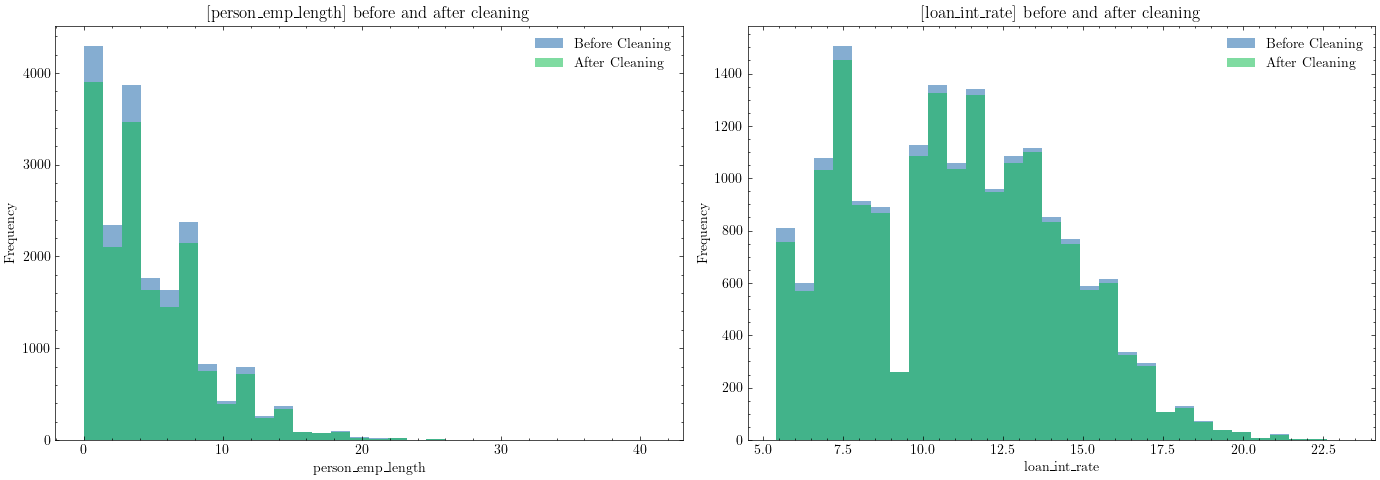

In [6]:
# distribution of person_emp_length before and after cleaning
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cols = ['person_emp_length', 'loan_int_rate']
for ax, col in zip(axes, cols):
    ax.hist(df[col].dropna(), bins=30, alpha=0.5, label='Before Cleaning')
    ax.hist(df_clean[col].dropna(), bins=30, alpha=0.5, label='After Cleaning')
    ax.set_title(f'[{col}] before and after cleaning')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()


In [7]:
df_clean.loan_status.value_counts(normalize=True)

loan_status
0    0.783146
1    0.216854
Name: proportion, dtype: float64

In [8]:
df_clean.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,17468.000000,1.746800e+04,17468.000000,17468.000000,17468.000000,17468.000000,17468.000000,17468.000000
mean,27.720975,6.673602e+04,4.785608,9648.704774,11.041588,0.216854,0.169041,5.787497
std,6.327470,6.787417e+04,4.053346,6335.021620,3.232953,0.412114,0.106508,4.035745
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.960000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.600000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,41.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


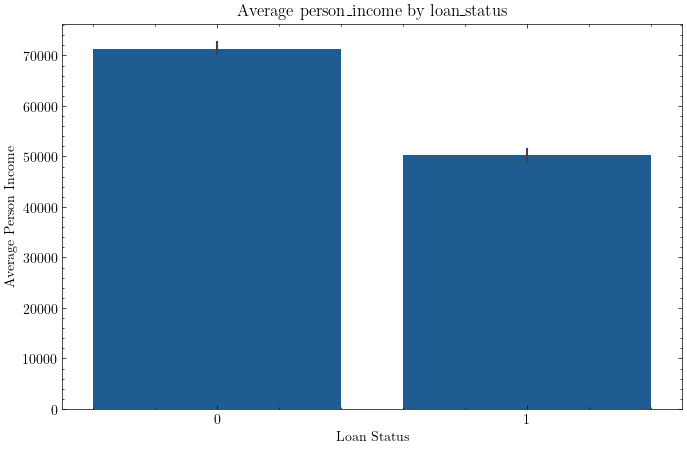

In [9]:
# Visualize average person_income by loan_status
plt.figure(figsize=(8, 5))
sns.barplot(x='loan_status', y='person_income', data=df_clean, estimator=np.mean)
plt.title('Average person_income by loan_status')
plt.xlabel('Loan Status')
plt.ylabel('Average Person Income')
plt.show()

In [10]:
# Hypothesis Testing: Is there a significant difference in average loan amount between good and bad loans?
from scipy.stats import ttest_ind

good_loans = df_clean[df_clean['loan_status'] == 0]['loan_amnt']
bad_loans = df_clean[df_clean['loan_status'] == 1]['loan_amnt']

ttest_result = ttest_ind(good_loans, bad_loans)
print(f"T-test statistic: {ttest_result.statistic}, p-value: {ttest_result.pvalue}")

T-test statistic: -14.9568449143555, p-value: 2.8773750940244435e-50


# Credit Scoring

## Development

In [19]:
variable_names = list(df_clean.drop(columns=['loan_status']).columns)

In [20]:
X = df_clean[variable_names]

In [14]:
target = "loan_status"
y = df_clean[target].values

In [17]:
df_clean.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
2,25,34000,MORTGAGE,2.0,HOMEIMPROVEMENT,C,5800,13.48,1,0.17,Y,3
3,25,118000,MORTGAGE,8.0,HOMEIMPROVEMENT,A,15000,7.88,0,0.13,N,4
4,22,96000,MORTGAGE,6.0,EDUCATION,C,6000,13.49,0,0.06,N,3
6,26,116004,MORTGAGE,11.0,VENTURE,B,20000,12.21,0,0.17,N,2
7,22,47484,MORTGAGE,0.0,EDUCATION,B,5325,10.62,0,0.11,N,4


In [18]:
selection_criteria = {
    "iv": {"min": 0.02, "max": 1},
    "quality_score": {"min": 0.01}
}

In [22]:
binning_process = BinningProcess(variable_names, selection_criteria=selection_criteria)

In [23]:
estimator = LogisticRegression(solver="lbfgs")

In [24]:
scorecard = Scorecard(binning_process=binning_process,
                      estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 300, "max": 850})

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [56]:
scorecard.fit(X_train, y_train, show_digits=4)

Scorecard(binning_process=BinningProcess(selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.02},
                                                             'quality_score': {'min': 0.01}},
                                         variable_names=['person_age',
                                                         'person_income',
                                                         'person_home_ownership',
                                                         'person_emp_length',
                                                         'loan_intent',
                                                         'loan_grade',
                                                         'loan_amnt',
                                                         'loan_int_rate',
                                                         'loan_percent_income',
                                                         'cb_person_default_on_file',
                                                         'cb_person_cred_hist_length']),
          estimator=LogisticRegression(), scaling_method='min_max',
          scaling_method_params={'max': 850, 'min': 300})

In [26]:
scorecard.information(print_level=2)

optbinning (Version 0.20.1)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                   min_max   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                  17468
    Number of variables                   11
    Target type                       binary

    Number of numerical                    7
    Number of categorical                  4
    Number of selected                     7

  Timing
    Total time                          0.88 sec
    Binning process                     0.83 sec   ( 94.01%)
    Estimator                           0.03 sec   (  3.02%

## Monitoring

In [57]:
monitoring = ScorecardMonitoring(scorecard=scorecard, psi_method="cart",
                                 psi_n_bins=10, verbose=True)

In [58]:
monitoring.fit(X_test, y_test, X_train, y_train)

2025-11-06 21:04:16,013 | INFO : Monitoring started.
2025-11-06 21:04:16,014 | INFO : Options: check parameters.
2025-11-06 21:04:16,015 | INFO : System stability analysis started.
2025-11-06 21:04:16,107 | INFO : System stability analysis terminated. Time: 0.0909s
2025-11-06 21:04:16,108 | INFO : Variable analysis started.
2025-11-06 21:04:16,145 | INFO : Variable analysis terminated. Time: 0.0354s
2025-11-06 21:04:16,147 | INFO : Monitoring terminated. Time: 0.1329s


ScorecardMonitoring(psi_n_bins=10,
                    scorecard=Scorecard(binning_process=BinningProcess(selection_criteria={'iv': {'max': 1,
                                                                                                  'min': 0.02},
                                                                                           'quality_score': {'min': 0.01}},
                                                                       variable_names=['person_age',
                                                                                       'person_income',
                                                                                       'person_home_ownership',
                                                                                       'person_emp_length',
                                                                                       'loan_intent',
                                                                                       'loan_grade',
                                                                                       'loan_amnt',
                                                                                       'loan_int_rate',
                                                                                       'loan_percent_income',
                                                                                       'cb_person_default_on_file',
                                                                                       'cb_person_cred_hist_length']),
                                        estimator=LogisticRegression(),
                                        scaling_method='min_max',
                                        scaling_method_params={'max': 850,
                                                               'min': 300}),
                    verbose=True)

In [59]:
monitoring.information(print_level=2)

optbinning (Version 0.20.1)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    scorecard                            yes   * U
    psi_method                          cart   * d
    psi_n_bins                            10   * U
    psi_min_bin_size                    0.05   * d
    show_digits                            2   * d
    verbose                             True   * U
  End options

  Statistics
    Number of records Actual            5241
    Number of records Expected         12227
    Number of scorecard variables          7
    Target type                       binary

  Timing
    Total time                          0.13 sec
    System stability                    0.09 sec   ( 68.35%)
    Variables stability                 0.04 sec   ( 26.63%)



In [60]:
monitoring.psi_table()

,Bin,Count A,Count E,Count A (%),Count E (%),PSI
0,"(-inf, 488.56)",325,745,0.062011,0.060931,0.000019
1,"[488.56, 525.76)",256,640,0.048846,0.052343,0.000242
2,"[525.76, 559.43)",300,710,0.057241,0.058068,0.000012
3,"[559.43, 595.44)",436,979,0.083190,0.080069,0.000119
4,"[595.44, 622.30)",438,1002,0.083572,0.081950,0.000032
5,"[622.30, 663.00)",840,2011,0.160275,0.164472,0.000109
6,"[663.00, 674.87)",283,679,0.053997,0.055533,0.000043
7,"[674.87, 726.79)",1268,3008,0.241939,0.246013,0.000068
8,"[726.79, 764.04)",725,1560,0.138332,0.127586,0.000869
9,"[764.04, inf)",370,893,0.070597,0.073035,0.000083


<Figure size 1000x400 with 0 Axes>

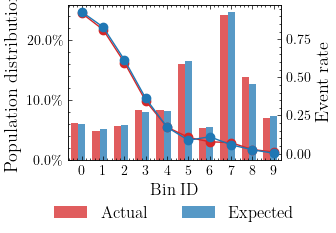

In [ ]:
plt.figure(figsize=(10, 4))
monitoring.psi_plot()

In [64]:
monitoring.tests_table()

,Bin,Count A,Count E,Event rate A,Event rate E,statistic,p-value
0,"(-inf, 488.56)",325,745,0.920000,0.928859,0.259716,0.610316
1,"[488.56, 525.76)",256,640,0.812500,0.829688,0.373774,0.540954
2,"[525.76, 559.43)",300,710,0.596667,0.614085,0.268669,0.604226
3,"[559.43, 595.44)",436,979,0.344037,0.361593,0.405477,0.524274
4,"[595.44, 622.30)",438,1002,0.173516,0.172655,0.001581,0.968284
5,"[622.30, 663.00)",840,2011,0.105952,0.087519,2.388036,0.122267
6,"[663.00, 674.87)",283,679,0.077739,0.110457,2.358403,0.124610
7,"[674.87, 726.79)",1268,3008,0.071767,0.057513,3.128229,0.076947
8,"[726.79, 764.04)",725,1560,0.026207,0.025000,0.029143,0.864448
9,"[764.04, inf)",370,893,0.010811,0.002240,4.064903,0.043783


In [68]:
monitoring.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.0016 (No significant change)

         PSI bin  Count  Count (%)
    [0.00, 0.10)     10        1.0
    [0.10, 0.25)      0        0.0
    [0.25, Inf+)      0        0.0

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      1        0.1
    [0.05, 0.10)      1        0.1
    [0.10, 0.50)      2        0.2
    [0.50, 1.00)      6        0.6

  Target analysis

               Metric  Actual Actual (%)  Expected Expected (%)
    Number of records    5241          -     12227            -
        Event records    1137   0.216943      2651     0.216815
    Non-event records    4104   0.783057      9576     0.783185

  Performance metrics

                 Metric   Actual  Expected  Diff A - E
     True positive rate 0.601583  0.620521   -0.018937
     True negative rate 0.954

In [69]:
monitoring.psi_variable_table(style="detailed")

,Variable,Bin,Count A,Count E,Count A (%),Count E (%),PSI
0,person_income,"(-inf, 24204.0000)",312,686,0.059531,0.056105,2.029818e-04
1,person_income,"[24204.0000, 34991.5000)",661,1524,0.126121,0.124642,1.744138e-05
2,person_income,"[34991.5000, 39780.0000)",367,846,0.070025,0.069191,9.984691e-06
3,person_income,"[39780.0000, 49994.0000)",760,1849,0.145010,0.151223,2.605866e-04
4,person_income,"[49994.0000, 59748.5000)",700,1636,0.133562,0.133802,4.306703e-07
5,person_income,"[59748.5000, 79428.0000)",1144,2571,0.218279,0.210272,2.992090e-04
6,person_income,"[79428.0000, 89385.0000)",338,753,0.064492,0.061585,1.340328e-04
7,person_income,"[89385.0000, inf)",959,2362,0.182980,0.193179,5.531625e-04
0,person_home_ownership,[OWN],404,922,0.077085,0.075407,3.691470e-05
1,person_home_ownership,[MORTGAGE],2173,5074,0.414616,0.414983,3.259530e-07


In [70]:
monitoring.psi_variable_table(style="summary")

,Variable,PSI
0,cb_person_default_on_file,0.000492
1,loan_amnt,0.002183
2,loan_grade,0.000203
3,loan_intent,0.002813
4,loan_percent_income,0.001496
5,person_home_ownership,0.000041
6,person_income,0.001478
